In [104]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [152]:
import pandas as pd
import pdb
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Dense, Flatten, Reshape, merge, Highway, Activation,Dropout
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import GlobalMaxPooling3D, MaxPooling3D, AveragePooling3D,GlobalAveragePooling3D
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianDropout
from keras.optimizers import Adamax, Adam, Nadam
from keras.layers.advanced_activations import ELU,PReLU,LeakyReLU
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from keras.regularizers import l2
from pylab import imshow, show
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import os
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,LearningRateScheduler
from sklearn.metrics import accuracy_score, log_loss,roc_auc_score
from sklearn.linear_model import LogisticRegression
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from skimage import measure, morphology
import SimpleITK as sitk
from PIL import Image
from scipy import ndimage
import threading
from multiprocessing import Process
from keras.regularizers import l2

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

In [153]:
def conv_block(x_input, num_filters, pool=True, norm=True, drop_rate=0.0):

    x1 = Conv3D(num_filters,3,3,3,border_mode='same',W_regularizer=l2(1e-4), data_format='channels_first')(x_input)
    
    if norm:
        x1 = BatchNormalization(axis=1)(x1)
    
    x1 = GaussianDropout(drop_rate)(x1)
    x1 = LeakyReLU(.1)(x1)
    
    if pool:
        x1 = MaxPooling3D(dim_ordering="th")(x1)
        
    x_out = x1
    
    return x_out

In [154]:
def dense_branch(xstart, name, outSize=1, activation='sigmoid'):
    
    xdense = Dense(32, W_regularizer=l2(1e-4))(xstart)
    xdense = BatchNormalization()(xdense)
    xdense = LeakyReLU(.1)(xdense)
    xout = Dense(outSize, activation=activation, name=name, W_regularizer=l2(1e-4))(xdense)
    
    return xout

In [155]:
def build_model(input_shape):

    xin = Input(input_shape)

    x1 = conv_block(xin, 8, drop_rate=0) #outputs 9 ch
    x1_ident = AveragePooling3D(dim_ordering="th")(xin)
    x1_merged = merge([x1, x1_ident], mode='concat', concat_axis=1)
    
    x2_1 = conv_block(x1_merged, 24, drop_rate=0) #outputs 16+9 ch  = 25
    x2_ident = AveragePooling3D(dim_ordering="th")(x1_ident)
    x2_merged = merge([x2_1, x2_ident], mode='concat', concat_axis=1)
    
    #by branching we reduce the #params
    x3_1 = conv_block(x2_merged,64,norm=True,drop_rate=0) #outputs 25 + 16 ch = 41
    x3_ident = AveragePooling3D(dim_ordering="th")(x2_ident)
    x3_merged = merge([x3_1,x3_ident],mode='concat', concat_axis=1)

    x4_1 = conv_block(x3_merged,72,norm=True,drop_rate=0) #outputs 25 + 16 ch = 41
    x4_ident = AveragePooling3D(dim_ordering="th")(x3_ident)
    x4_merged = merge([x4_1,x4_ident],mode='concat', concat_axis=1)
    

    x5_1 = conv_block(x4_merged, 72, norm=True, pool=False, drop_rate=0) #outputs 25 + 16 ch = 41

    xpool = GlobalMaxPooling3D()(x5_1)
    xpool_norm = BatchNormalization()(xpool)

    xout_cad_falsepositive = dense_branch(xpool_norm, name='o_fp', outSize=3, activation='softmax')
    xout_malig = dense_branch(xpool_norm,name='o_mal',outSize=1,activation='sigmoid')
    
    model = Model(input=xin, output=[xout_malig, xout_cad_falsepositive])

    
    if input_shape[1] == 32:
        lr_start = .005
    elif input_shape[1] == 64:
        lr_start = .001
    elif input_shape[1] == 128:
        lr_start = 1e-4
    elif input_shape[1] == 96:
        lr_start = 5e-4
    
    opt = Nadam(lr_start, clipvalue=1.0)
    print ('compiling model')

    model.compile(optimizer=opt,\
                  loss={'o_mal':'binary_crossentropy', 'o_fp':'categorical_crossentropy'})
    return model

In [156]:
def str_to_arr(arr_str,length):
    while '  ' in arr_str:
        arr_str = arr_str.replace('  ', ' ')
    result = eval(arr_str.replace('[ ', '[').replace(' ]', ']').replace(' ', ','))
    assert len(result) == length
    return np.array(result)

In [157]:
def get_generator_static(X1,X2,IX1,IX2,batch_size,augment=True,current_frac=.75):

    df = pd.read_csv('/home/katya/data/CSVFILES/annotations_enhanced.csv')
    
    Ycad_fp = np.zeros((df.shape[0],3)).astype('float32')
    Ycad_fp[:,0] = 1.0
    #3 categories - [nodule, cad false positive, random subvoxel]

    df['malignancy'] /= 5.

    Ymalig = df['malignancy'].values

    while True:
        
        n1 = int(current_frac * batch_size)
        n2 = batch_size - n1
        
        ixs1 = np.random.choice(range(X1.shape[0]), size=n1, replace=False)
        ixs2 = np.random.choice(range(X2.shape[0]), size=n2, replace=False)
        Xbatch1, IXbatch1 = X1[ixs1], IX1[ixs1]
        Xbatch2, IXbatch2 = X2[ixs2], IX2[ixs2]
        
        Xbatch = np.concatenate([Xbatch1, Xbatch2], axis=0)
        IXbatch = np.concatenate([IXbatch1, IXbatch2], axis=0)
        IXbatch_eq_neg2 = (IXbatch == -2)
        IXbatch[IXbatch_eq_neg2] = -1
        #this way things that are -2 (cad false positives)
        #get labeled as non-nodules for everything else.
        #but we still know where they are.
        IXbatch_eq_neg1 = (IXbatch == -1)
        
        #making sure we don't use these.
        #row 32 is a big tumor so it should be obvious
        
        #normalize
        Xbatch = np.expand_dims(Xbatch, 1)
        if augment:
            Xbatch = random_perturb(Xbatch)
        Xbatch = Xbatch.astype('float32')
        Xbatch = (Xbatch + 1000.) / (400. + 1000.)
        Xbatch = np.clip(Xbatch,0,1)
        
        Ybatch_malig = Ymalig[IXbatch]
        Ybatch_malig[IXbatch_eq_neg1] = 0.0
        
        Ybatch_cad_fp = Ycad_fp[IXbatch]
        #class 0 things = nodules are already set.
        
        #-1 = random subvoxel, class 3
        Ybatch_cad_fp[IXbatch_eq_neg1,2] = 1.0
        Ybatch_cad_fp[IXbatch_eq_neg1,0] = 0.0
        Ybatch_cad_fp[IXbatch_eq_neg1,1] = 0.0
        
        #-2 = cad false positive, class 2
        Ybatch_cad_fp[IXbatch_eq_neg2,1] = 1.0
        Ybatch_cad_fp[IXbatch_eq_neg2,0] = 0.0
        Ybatch_cad_fp[IXbatch_eq_neg2,2] = 0.0
                
        
        yield Xbatch, {'o_mal':Ybatch_malig, 'o_fp':Ybatch_cad_fp}        

In [158]:
def stage_1_lr_schedule(i):
    if i < 10:
        return np.float32(.004)
    if i < 15:
        return np.float32(.002)
    if i < 20:
        return np.float32(.0005)
    if i < 23:
        return np.float32(.0001)
    return np.float32(3e-5)

def stage_2_lr_schedule(i):
    if i == 0:
        return np.float32(.001)
    if i < 5:
        return np.float32(.0004)
    if i < 10:
        return np.float32(.0002)
    return np.float32(3e-5)

In [185]:
def train_model_on_stage(model, subset, batch_size=10):
    
    subset=str(subset)
    Xpos = np.load('/home/katya/data/voxels_true64/subset' + subset + 'Xtrue.npy')
    IXpos = np.load('/home/katya/data/voxels_true64/subset' + subset + 'IXtrue.npy')
    Xneg = np.load('/home/katya/data/voxels_random64/subset' + subset + 'Xrandom.npy')
    IXneg = np.load('/home/katya/data/voxels_random64/subset' + subset + 'IXrandom.npy')
    train_generator_75 = get_generator_static(Xpos, Xneg, IXpos, IXneg, \
                                              augment=False, batch_size=batch_size, \
                                              current_frac=.33)


    name = 'model_LUNA_v1_{epoch:02d}.h5'
    chkp = ModelCheckpoint(filepath=name)

    lr_schedule = LearningRateScheduler(stage_2_lr_schedule)
    nb_epoch = 15
    samples_per_epoch = 10
        
    lossHist = []
    
    for epoch in range(nb_epoch):
        hist = model.fit_generator(train_generator_75, samples_per_epoch=samples_per_epoch*batch_size, \
                            nb_epoch=epoch+1,callbacks=[chkp,lr_schedule],initial_epoch=epoch)
        lossHist.append(hist.history['loss'])

        
    return model, lossHist

In [186]:
model_64 = build_model((1,64,64,64))

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(8, (3, 3, 3), padding="same", kernel_regularizer=<keras.reg..., data_format="channels_first")`
  app.launch_new_instance()
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(data_format="channels_first")`
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `AveragePooling3D` call to the Keras 2 API: `AveragePooling3D(data_format="channels_first")`
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/opt/anaconda/lib/python3.5/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Us

compiling model


/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_regularizer=<keras.reg..., name="o_fp", activation="softmax")`
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., name="o_mal", activation="sigmoid")`
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [190]:
lossHist = []

for i in range(1,10):
    print (i)
    model_64.load_weights('/home/katya/LungCancer/Katya/CNN_v1/model_v1_weights_temp64.h5')
    model_64, hist = train_model_on_stage(model_64, subset = i, batch_size=15)
    lossHist.extend(hist)
    model_64.save_weights('/home/katya/LungCancer/Katya/CNN_v1/model_v1_weights_temp64.h5')

1
Epoch 1/1


/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=0, epochs=1)`


150/150 [==============================] - 231s - loss: 0.8907 - o_mal_loss: 0.3654 - o_fp_loss: 0.4634     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=1, epochs=2)`


150/150 [==============================] - 234s - loss: 0.7134 - o_mal_loss: 0.3140 - o_fp_loss: 0.3351     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=2, epochs=3)`


150/150 [==============================] - 235s - loss: 0.6065 - o_mal_loss: 0.2785 - o_fp_loss: 0.2641     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=3, epochs=4)`


150/150 [==============================] - 234s - loss: 0.5420 - o_mal_loss: 0.2601 - o_fp_loss: 0.2182     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=4, epochs=5)`


150/150 [==============================] - 234s - loss: 0.4635 - o_mal_loss: 0.2402 - o_fp_loss: 0.1597     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=5, epochs=6)`


150/150 [==============================] - 235s - loss: 0.4052 - o_mal_loss: 0.2247 - o_fp_loss: 0.1170     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=6, epochs=7)`


150/150 [==============================] - 234s - loss: 0.3644 - o_mal_loss: 0.2138 - o_fp_loss: 0.0874     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=7, epochs=8)`


150/150 [==============================] - 234s - loss: 0.3241 - o_mal_loss: 0.2048 - o_fp_loss: 0.0563     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=8, epochs=9)`


150/150 [==============================] - 234s - loss: 0.3212 - o_mal_loss: 0.2013 - o_fp_loss: 0.0572     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=9, epochs=10)`


150/150 [==============================] - 235s - loss: 0.3063 - o_mal_loss: 0.1984 - o_fp_loss: 0.0455     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=10, epochs=11)`


150/150 [==============================] - 235s - loss: 0.2903 - o_mal_loss: 0.1934 - o_fp_loss: 0.0347     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=11, epochs=12)`


150/150 [==============================] - 234s - loss: 0.2925 - o_mal_loss: 0.1940 - o_fp_loss: 0.0362     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=12, epochs=13)`


150/150 [==============================] - 235s - loss: 0.2826 - o_mal_loss: 0.1909 - o_fp_loss: 0.0296     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=13, epochs=14)`


150/150 [==============================] - 235s - loss: 0.2759 - o_mal_loss: 0.1881 - o_fp_loss: 0.0256     

/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=150, initial_epoch=14, epochs=15)`


150/150 [==============================] - 235s - loss: 0.2740 - o_mal_loss: 0.1865 - o_fp_loss: 0.0255     

KeyboardInterrupt: 

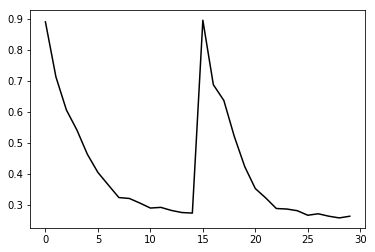

In [194]:
plt.plot([x for x in range(len(lossHist))], lossHist, '-k');

In [192]:
%matplotlib inline